In [1]:
import numpy as np
import random
import book_plots
from book_plots import figsize, set_figsize
import matplotlib.pyplot as plt
from filterpy.discrete_bayes import normalize
from filterpy.discrete_bayes import update
from filterpy.discrete_bayes import predict

In [2]:
def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

## Discrete Bayes Train example

In [3]:
class Train(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
         # insert random sensor error
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

With that we are ready to write the filter. We will put it in a function so that we can run it with different assumptions. I will assume that the robot always starts at the beginning of the track. The track is implemented as being 10 units long, but think of it as a track of length, say 10,000, with the magnet pattern repeated every 10 units. A length of 10 makes it easier to plot and inspect.

In [4]:
def train_filter(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    prior = np.array([.9] + [0.01]*9)
    normalize(prior)
    
    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        robot.move(distance=move_distance)
        m = robot.sense()
        if do_print:
            print('''time {}: pos {}, sensed {}, '''
                  '''at position {}'''.format(
                    i, robot.pos, m, track[robot.pos]))

        likelihood = lh_hallway(track, m, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)
        if i < iterations - 1:
            prior = predict(posterior, move_distance, kernel)       

        if do_print:
            print('''        predicted position is {}'''
                  ''' with confidence {:.4f}%:'''.format(
                  index, posterior[index]*100))            

    book_plots.bar_plot(posterior)
    if do_print:
        print()
        print('final position is', robot.pos)
        index = np.argmax(posterior)
        print('''predicted position is {} with '''
              '''confidence {:.4f}%:'''.format(
                index, posterior[index]*100))

time 0: pos 4, sensed 4, at position 4
        predicted position is 4 with confidence 91.0665%:
time 1: pos 8, sensed 8, at position 8
        predicted position is 8 with confidence 99.9902%:
time 2: pos 2, sensed 2, at position 2
        predicted position is 2 with confidence 100.0000%:
time 3: pos 6, sensed 6, at position 6
        predicted position is 6 with confidence 100.0000%:

final position is 6
predicted position is 6 with confidence 100.0000%:


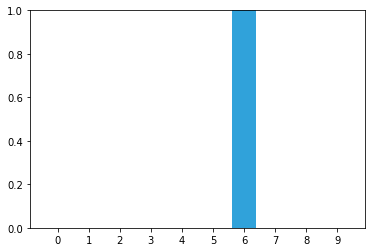

In [5]:
random.seed(3)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
train_filter(4, kernel=[1.], sensor_accuracy=.999, move_distance=4, do_print=True)

time 0: pos 4, sensed 4, at position 4
        predicted position is 0 with confidence 84.1121%:
time 1: pos 8, sensed 9, at position 8
        predicted position is 4 with confidence 59.4728%:
time 2: pos 3, sensed 3, at position 3
        predicted position is 3 with confidence 53.5807%:
time 3: pos 7, sensed 8, at position 7
        predicted position is 8 with confidence 37.5836%:

final position is 7
predicted position is 8 with confidence 37.5836%:


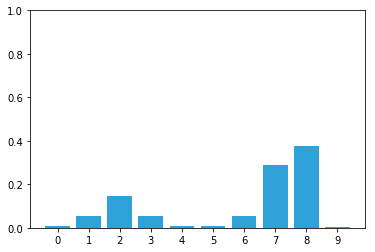

In [6]:
random.seed(5)
train_filter(4, kernel=[.1, .8, .1], sensor_accuracy=.9,
         move_distance=4, do_print=True)

There was a sensing error at time 1, but we are still quite confident in our position.

Now let's run a very long simulation and see how the filter responds to errors.

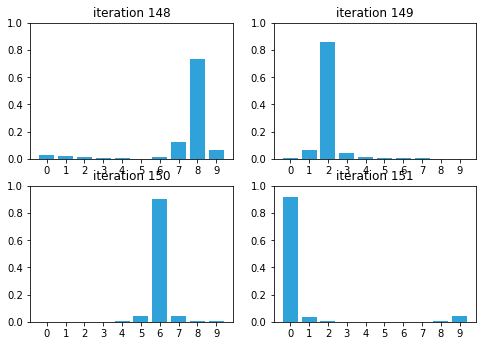

In [7]:
with figsize(y=5.5):
    for i in range (4):
        random.seed(3)
        plt.subplot(221+i)
        train_filter(148+i, kernel=[.1, .8, .1], 
                     sensor_accuracy=.8,
                     move_distance=4, do_print=False)
        plt.title ('iteration {}'.format(148+i))